In [2]:
import pandas as pd
from get_sentiment import *
import nltk
import spacy
from spacy.tokens import Doc
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dizquierdo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [110]:
results = primary_species(['Candidate', 'Tweet'], 'text', 'timestamp')

data = read_cypher(results, index_col='timestamp')

In [111]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def sentiment(doc):
    """Returns polarity score set earlier to Vader's analyzer"""
    return sentiment_analyzer.polarity_scores(doc)['compound']

In [112]:
len(data)

464

In [113]:
data.name.value_counts()

BernieSanders    135
PeteButtigieg    105
JoeBiden          72
MikeBloomberg     71
amyklobuchar      38
AndrewYang        29
TulsiGabbard      14
Name: name, dtype: int64

In [114]:
data['clean_text'], data['hashtag'] = zip(*data.text.map(strip_tweets))

In [115]:
data = pd.merge(data, pd.get_dummies(data.hashtag.apply(pd.Series).stack()).sum(level=0), how='left', left_index=True, right_index=True).drop(['hashtag','followers'], axis=1).fillna(0)


In [116]:
data.iloc[357][['clean_text']][0]

'Senator Sanders at one point said his health care plan was going to cost $40 trillion, then it was $30 trillion, th… '

In [117]:
data['sentiment'] = data.text.apply(sentiment)

In [118]:
data.iloc[0]['timestamp']

1560379580.0

In [119]:
data.head()

,name,text,timestamp,clean_text,#1,#BloombergGBF,#CNNTownHall,#DemDebate,#LetYangSpeak,#PayToPlay,#StandWithTulsi,#SuperBowl,#TULSI2020,#TeamPete,#danggang,#sb150,#southbend,#stuffmayorsdo,#yanggang,sentiment
0,BernieSanders,"In 1944, FDR proposed an economic bill of righ...",1.560380e+09,"In 1944, FDR proposed an economic bill of righ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7586
1,BernieSanders,75 years after FDR proposed an economic bill o...,1.560368e+09,75 years after FDR proposed an economic bill o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,BernieSanders,Housing must be a right. We will:\n\n✅Build an...,1.568513e+09,Housing must be a right. We will:\n\n✅Build an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
3,BernieSanders,"You want to keep the minimum wage low, and giv...",1.450940e+09,"You want to keep the minimum wage low, and giv...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5106
4,BernieSanders,"No patient should be sued, go into debt or go ...",1.582940e+09,"No patient should be sued, go into debt or go ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.9231


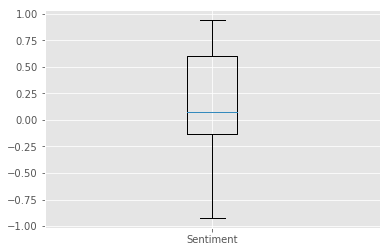

In [120]:
plt.boxplot(data.sentiment, labels=['Sentiment']);

In [121]:
data.groupby(by='name').sentiment.mean()

name
AndrewYang       0.289503
BernieSanders    0.179694
JoeBiden         0.119796
MikeBloomberg   -0.006424
PeteButtigieg    0.162730
TulsiGabbard     0.195271
amyklobuchar     0.254547
Name: sentiment, dtype: float64

In [122]:
data.set_index(pd.to_datetime(data.timestamp, utc=True, unit='s'), inplace=True)

In [123]:
data.drop(['timestamp'], axis=1, inplace=True)

In [124]:
data.head()

,name,text,clean_text,#1,#BloombergGBF,#CNNTownHall,#DemDebate,#LetYangSpeak,#PayToPlay,#StandWithTulsi,#SuperBowl,#TULSI2020,#TeamPete,#danggang,#sb150,#southbend,#stuffmayorsdo,#yanggang,sentiment
timestamp,,,,,,,,,,,,,,,,,,,
2019-06-12 22:46:20+00:00,BernieSanders,"In 1944, FDR proposed an economic bill of righ...","In 1944, FDR proposed an economic bill of righ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7586
2019-06-12 19:40:00+00:00,BernieSanders,75 years after FDR proposed an economic bill o...,75 years after FDR proposed an economic bill o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2019-09-15 02:01:03+00:00,BernieSanders,Housing must be a right. We will:\n\n✅Build an...,Housing must be a right. We will:\n\n✅Build an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2015-12-24 07:01:02+00:00,BernieSanders,"You want to keep the minimum wage low, and giv...","You want to keep the minimum wage low, and giv...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5106
2020-02-29 01:37:22+00:00,BernieSanders,"No patient should be sued, go into debt or go ...","No patient should be sued, go into debt or go ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.9231


In [125]:
set(data.name.values)

{'AndrewYang',
 'BernieSanders',
 'JoeBiden',
 'MikeBloomberg',
 'PeteButtigieg',
 'TulsiGabbard',
 'amyklobuchar'}

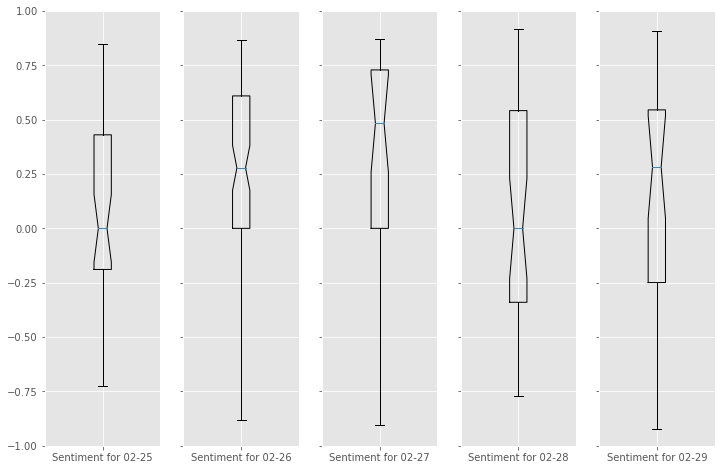

In [106]:
days = set(data['2020-02-25':'2020-02-29'].day.values)
fig, ax = plt.subplots(1,len(days), figsize=(12,8), sharey=True)
for count, day in enumerate(days):
    subset = data['2020-02-25':'2020-02-29'].query(f'day =={day}')
    ax[count].boxplot(subset.sentiment, notch=True, labels=[f'Sentiment for 02-{day}'])
    axes = plt.gca()
    axes.set_ylim([-1,1])
#     axes.set_yticklabels(map(lambda x: x/10, list(range(-10,10))))

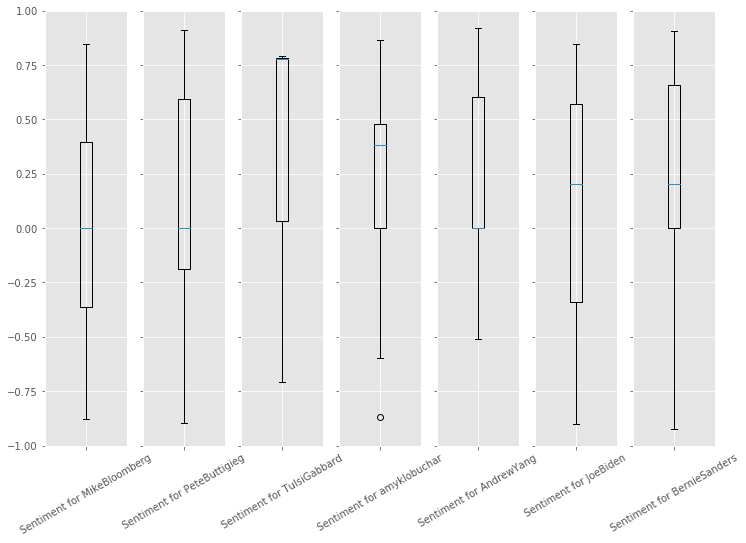

In [148]:
candidates = set(data['2020-02-25':'2020-02-29'].name.values)
fig, ax = plt.subplots(1,len(candidates), figsize=(12,8), sharey=True)
for count, candidate in enumerate(candidates):
    subset = data['2020-02-25':'2020-02-29'].query(f'name=="{candidate}"')
    ax[count].boxplot(subset.sentiment, notch=False, labels=[f'Sentiment for {candidate}'])
    axes = plt.gca()
    axes.set_ylim([-1,1])
    for tick in ax[count].get_xticklabels():
        tick.set_rotation(30)
#     axes.set_yticklabels(map(lambda x: x/10, list(range(-10,10))))

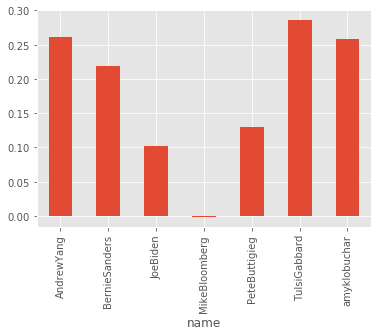

In [150]:
candidate_mean = data['2020-02-25':'2020-02-29'].groupby('name').sentiment.mean()
candidate_mean.plot(kind='bar');

In [152]:
data['day'] = data.index.day

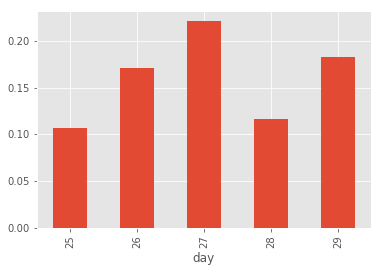

In [153]:
day_mean = data['2020-02-25':'2020-02-29'].groupby('day').sentiment.mean()
day_mean.plot(kind='bar');

In [176]:
min_sent_tweet

'No patient should be sued, go into debt or go bankrupt for the "crime" of getting sick. We must remove the greed fr… https://t.co/s1XaPQ1Cc2'

In [192]:
data.sentiment.max()

0.9392

In [195]:
data.query('name == "JoeBiden"').sentiment.max()

0.9392

In [198]:
data[(data['sentiment'] == max_sentiment)].values

array([['JoeBiden',
        "A giant among men, a civil rights hero, and a man I'm honored to call a friend — Happy Birthday, Congressman Lewis!… https://t.co/vypBc8B6X9",
        "A giant among men, a civil rights hero, and a man I'm honored to call a friend — Happy Birthday, Congressman Lewis!… ",
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.9392, 22]], dtype=object)

In [200]:
data.query(f'sentiment== {max_sentiment}')

,name,text,clean_text,#1,#BloombergGBF,#CNNTownHall,#DemDebate,#LetYangSpeak,#PayToPlay,#StandWithTulsi,#SuperBowl,#TULSI2020,#TeamPete,#danggang,#sb150,#southbend,#stuffmayorsdo,#yanggang,sentiment,day
timestamp,,,,,,,,,,,,,,,,,,,,
2020-02-22 01:07:56+00:00,JoeBiden,"A giant among men, a civil rights hero, and a ...","A giant among men, a civil rights hero, and a ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9392,22


In [264]:
tick = g.yaxis.get_major_ticks()[1]

In [265]:
tick.label

Text(0,1,'MikeBloomberg')

In [266]:
tick.label1.get_text()

'MikeBloomberg'

In [267]:
tick.get_loc()

1

In [274]:
tick.label.get_position()[1]

1

In [292]:
[print(tick.label) for tick in g.yaxis.get_major_ticks()]

Text(0,0,'BernieSanders')
Text(0,1,'MikeBloomberg')
Text(0,2,'JoeBiden')
Text(0,3,'PeteButtigieg')
Text(0,4,'amyklobuchar')
Text(0,5,'AndrewYang')
Text(0,6,'TulsiGabbard')


[None, None, None, None, None, None, None]

In [290]:
max_sent_y

0

In [291]:
min_sent_y

0

Text(0,0,'BernieSanders')
BernieSanders
(0, 0)
Text(0,0,'MikeBloomberg')
MikeBloomberg
(0, 0)
Text(0,0,'JoeBiden')
JoeBiden
(0, 0)
Text(0,0,'PeteButtigieg')
PeteButtigieg
(0, 0)
Text(0,0,'amyklobuchar')
amyklobuchar
(0, 0)
Text(0,0,'AndrewYang')
AndrewYang
(0, 0)
Text(0,0,'TulsiGabbard')
TulsiGabbard
(0, 0)


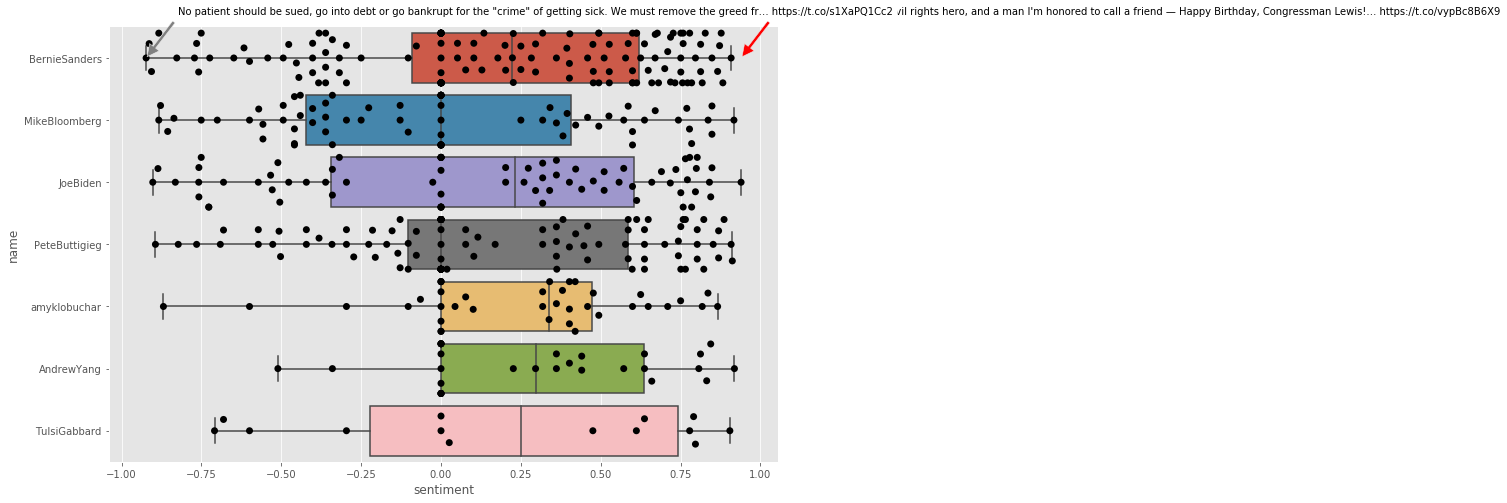

In [298]:
max_sentiment = data.sentiment.max()
min_sentiment = data.sentiment.min()
max_sent_tweet = data[(data['sentiment'] == max_sentiment)]['text'].values[0]
min_sent_tweet = data[(data['sentiment'] == min_sentiment)]['text'].values[0]
max_sent_sender = data[(data['sentiment'] == max_sentiment)]['name'].values[0]
min_sent_sender = data[(data['sentiment'] == min_sentiment)]['name'].values[0]
g = sns.boxplot(y = "name",
              x = 'sentiment', 
              data = data, whis=np.inf)
g = sns.swarmplot(y = "name",
              x = 'sentiment', 
              data = data,
              # Decrease the size of the points to avoid crowding 
              size = 7,color='black')
# remove the top and right line in graph
sns.despine()
# Annotate. xy for coordinate. max_wage is x and 0 is y. In this plot y ranges from 0 to 7 for each level
# xytext for coordinates of where I want to put my text
for tick in g.yaxis.get_major_ticks():
    print(tick.label)
    print(tick.label.get_text())
    print(tick.label.get_position())
    if max_sent_sender == tick.label.get_text():
        max_sent_y = tick.label.get_position()[0]
    if min_sent_sender == tick.label.get_text():
        min_sent_y = tick.label.get_position()[0]
plt.annotate(s = max_sent_tweet,
             xy = (max_sentiment,max_sent_y),
             xytext = (max_sentiment+.1,max_sent_y-.7), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'red', 'width': 3, 'shrink': 0.03},
             backgroundcolor = 'white')
plt.annotate(s = min_sent_tweet,
             xy = (min_sentiment,min_sent_y),
             xytext = (min_sentiment+.1,min_sent_y-.7), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'gray', 'width': 3, 'shrink': 0.03},
             backgroundcolor = 'white')
g.figure.set_size_inches(12,8)
plt.show();

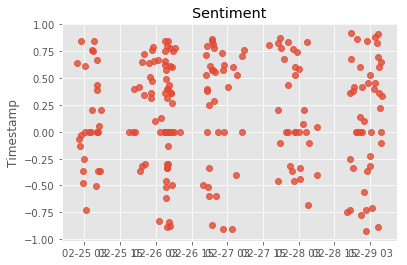

In [34]:
fig, ax = plt.subplots()
ax.plot(data.loc['2020-02-25':'2020-02-29', 'sentiment'], marker='o', alpha=.8, linestyle='None')
ax.set_ylabel('Timestamp')
ax.set_title('Sentiment');

In [36]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [39]:
data['day'] = data.index.day
# ax = plt.boxplot(data = data, x='Day',y='Sentiment')
# for item in ax.get_xticklabels():
#     item.set_rotation(90)

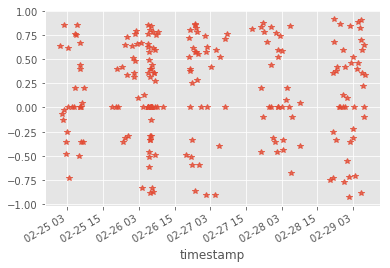

In [27]:
data.loc['2020-02-25':'2020-02-29', 'sentiment'].plot(marker='*', alpha=0.8, linestyle='None')

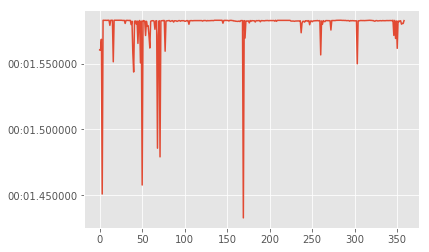

In [97]:
plt.plot(data.index)

In [5]:
tag_set.most_common(5)

[('#auspol', 359),
 ('#Australia', 350),
 ('#ClimateCrisis', 290),
 ('#ClimateActionNow', 271),
 ('#straya', 257)]

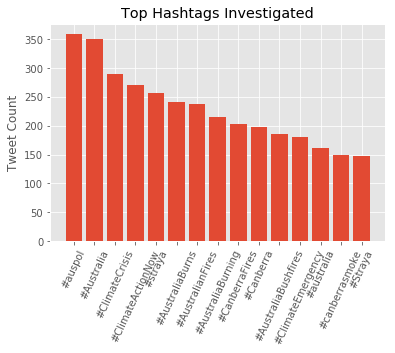

In [6]:
plt.bar([tag[0] for tag in tag_set.most_common(15)], [tag[1] for tag in tag_set.most_common(15)])
plt.xticks(rotation=65)
plt.ylabel('Tweet Count')
plt.title('Top Hashtags Investigated')
plt.show;

In [7]:
word_count = Counter(" ".join([re.sub(r'\s',' ',tweet[0]).strip() for tweet in clean_tweets]).split())

In [8]:
word_count.most_common(10)

[('the', 2174),
 ('to', 1612),
 ('of', 1041),
 ('a', 985),
 ('in', 966),
 ('and', 962),
 ('is', 721),
 ('for', 681),
 ('on', 452),
 ('this', 380)]

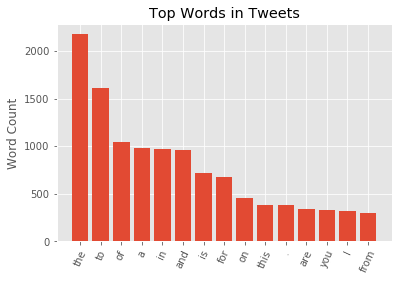

In [9]:
plt.bar([word[0] for word in word_count.most_common(15)], [word[1] for word in word_count.most_common(15)])
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show();

In [10]:
stopwords_list=stopwords.words('english') +list(string.punctuation)
stopwords_list += ["&amp;","'",'"','...','``','…','’','‘','“',"''",'""','”','”','co',"'s'",'\'s','n\'t','\'m','\'re','amp','https']
    

In [14]:
tweets = [tweet[0] for tweet in clean_tweets]

In [15]:
wordfrequency(tweets, 20)

[('fire', 303),
 ('australia', 266),
 ('day', 224),
 ('climate', 150),
 ('australian', 146),
 ('de', 134),
 ('like', 133),
 ('people', 129),
 ('time', 128),
 ('u', 123),
 ('need', 117),
 ('one', 113),
 ('get', 108),
 ('help', 107),
 ('change', 106),
 ('canberra', 96),
 ('see', 94),
 ('go', 93),
 ('new', 90),
 ('still', 90)]

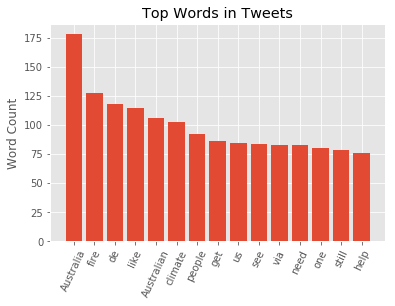

In [11]:
plt.bar([word[0] for word in word_count.most_common(100) if word[0].lower() not in stopwords_list][:15], [word[1] for word in word_count.most_common(100) if word[0].lower() not in stopwords_list][:15])
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show;

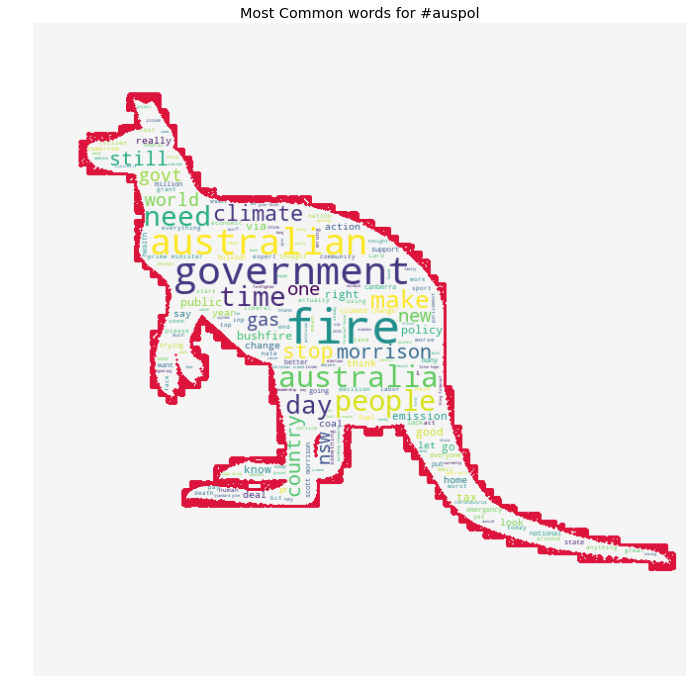

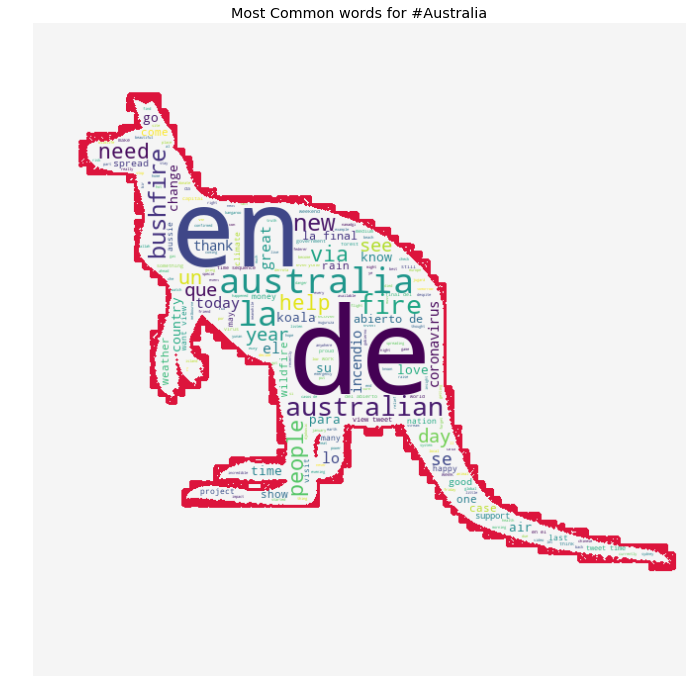

TypeError: sequence item 3550: expected str instance, tuple found

In [12]:
for tag in tag_set.most_common(5):
    subset = list(filter(lambda x: tag[0] in x[1], clean_tweets))
    create_wordcloud([tweet[0] for tweet in subset] , tag[0], 200)

In [5]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [15]:
from nltk.collocations import BigramCollocationFinder as big_find

In [36]:
tweets = [tweet[0] for tweet in clean_tweets]
vocab = tokenized(tweets)
big = big_find.from_words(vocab)
# b.apply_freq_filter(1)
big_measures = nltk.collocations.BigramAssocMeasures()
bestBigrams = big.above_score(score_fn=big_measures.raw_freq, min_score=1.0/len(tuple(nltk.bigrams(tweets))))
vocab += bestBigrams